In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import optuna
import json

from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data=pd.read_csv('./Data/playground-series-s4e9/train.csv')
test_data=pd.read_csv('./Data/playground-series-s4e9/test.csv')

In [ ]:
def accident_na_processing(df):
    if pd.isna(df.accident):
        df.accident='None reported'
    return df

def clean_title_na_processing(df):
    if pd.isna(df.clean_title):
        df.clean_title='No'
    return df

In [ ]:
def plot_non_binary_histograms(df):
    # Select only the numeric columns
    numeric_columns = df.select_dtypes(include=['number'])
    
    # Filter out columns that are not binary
    non_binary_columns = [col for col in numeric_columns if df[col].nunique() > 2]
    
    # Plot histograms for each column
    for col in non_binary_columns:
        plt.figure()
        df[col].hist(bins=30)  # Set the number of bins for the histogram to 30
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    return non_binary_columns


In [ ]:
def add_log_columns(df, columns):
    for column_name in columns:
        new_column_name = f"log_{column_name}"
        df[new_column_name] = np.log(df[column_name].replace(0, np.nan))  # 0をNaNに置き換えてlogのエラーを避ける
    return df

In [197]:
def data_EDA(df):
    df=df.apply(accident_na_processing,axis=1)
    df=df.apply(clean_title_na_processing,axis='columns')
    df['accident']=df.accident.apply(lambda x: 1 if x=='At least 1 accident or damage reported' else 0)
    df['clean_title']=df.clean_title.apply(lambda x: 1 if x=='Yes' else 0)
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
    df['engine_size'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
    df['cylinders'] = df['engine'].str.extract(r'(\d+) Cylinder').astype(float)

    categorical_columns = ['model', 'fuel_type', 'transmission', 'ext_col', 'int_col']
    numerical_columns = ['milage', 'model_year','horsepower', 'engine_size', 'cylinders', 'accident', 'clean_title']

    # 2. 对分类变量进行One-Hot编码
    X_categorical = pd.get_dummies(df[categorical_columns], drop_first=True)

    # 3. 将编码后的分类变量与数值变量合并
    X_numerical = df[numerical_columns]
    X = pd.concat([X_categorical, X_numerical], axis=1)
    df=pd.concat([df.price,X],axis=1)
    #df.dropna(inplace=True)
    X=df.drop(columns='price',axis=1)
    y=df.price
    



    return df,X,y


In [201]:
def data_EDA(train_data, test_data):
    # 1. 处理 train_data 和 test_data 的缺失值和相关数据
    train_data = train_data.apply(accident_na_processing, axis=1)
    test_data = test_data.apply(accident_na_processing, axis=1)
    
    train_data = train_data.apply(clean_title_na_processing, axis='columns')
    test_data = test_data.apply(clean_title_na_processing, axis='columns')
    
    train_data['accident'] = train_data.accident.apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)
    test_data['accident'] = test_data.accident.apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)
    
    train_data['clean_title'] = train_data.clean_title.apply(lambda x: 1 if x == 'Yes' else 0)
    test_data['clean_title'] = test_data.clean_title.apply(lambda x: 1 if x == 'Yes' else 0)

    # 2. 提取引擎相关特征（马力、发动机排量和气缸数）
    for df in [train_data, test_data]:
        df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
        df['engine_size'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
        df['cylinders'] = df['engine'].str.extract(r'(\d+) Cylinder').astype(float)

    # 3. 分类特征和数值特征
    categorical_columns = ['model', 'fuel_type', 'transmission', 'ext_col', 'int_col']
    numerical_columns = ['milage', 'model_year', 'horsepower', 'engine_size', 'cylinders', 'accident', 'clean_title']

    # 4. 对 train_data 和 test_data 同时进行 One-Hot 编码
    combined_data = pd.concat([train_data[categorical_columns], test_data[categorical_columns]], axis=0)  # 合并以保证编码一致
    combined_encoded = pd.get_dummies(combined_data, drop_first=True)

    # 5. 将编码后的分类变量分别与数值变量合并到 train_data 和 test_data
    X_train_categorical = combined_encoded.iloc[:len(train_data)]
    X_test_categorical = combined_encoded.iloc[len(train_data):]

    X_train_numerical = train_data[numerical_columns]
    X_test_numerical = test_data[numerical_columns]

    X_train = pd.concat([X_train_categorical, X_train_numerical], axis=1)
    X_test = pd.concat([X_test_categorical, X_test_numerical], axis=1)

    # 6. 删除 train_data 中的缺失值，并获取 X 和 y
    #train_data.dropna(inplace=True)
    y_train = train_data['price']  # train_data 中的目标变量
    X_train = X_train.loc[train_data.index]  # 确保 X_train 和 y_train 的索引一致
    
    return X_train, X_test, y_train


In [203]:
X_train, X_test, y_train=data_EDA(train_data, test_data)

In [162]:
X_train.shape

(150456, 2434)

In [164]:
def plot_non_binary_histograms(df):
    # Select only the numeric columns
    numeric_columns = df.select_dtypes(include=['number'])
    
    # Filter out columns that are not binary
    non_binary_columns = [col for col in numeric_columns if df[col].nunique() > 2]
    
    # Plot histograms for each column
    for col in non_binary_columns:
        plt.figure()
        df[col].hist(bins=30)  # Set the number of bins for the histogram to 30
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    return non_binary_columns

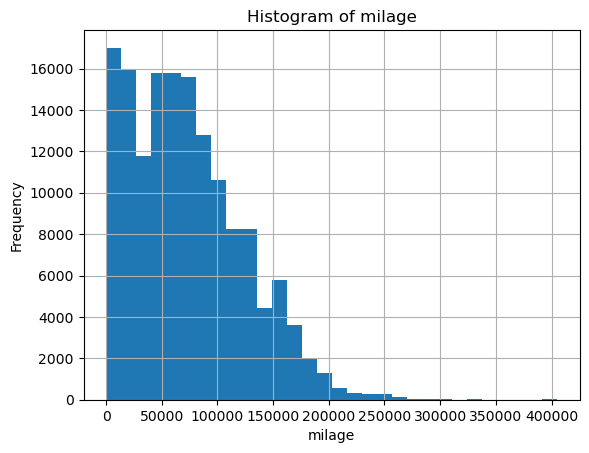

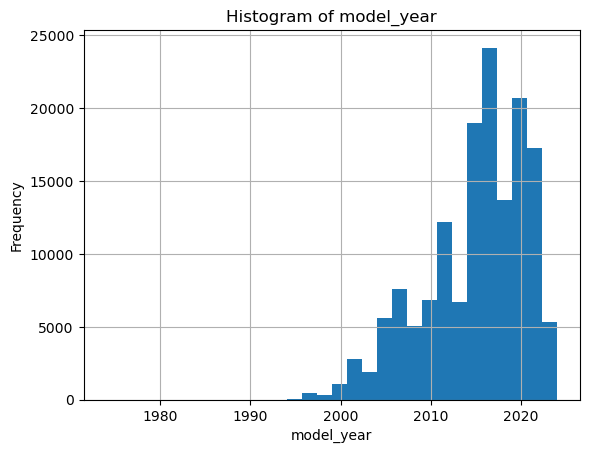

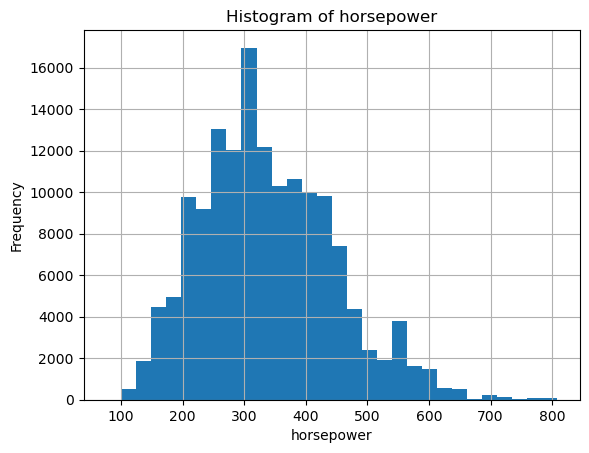

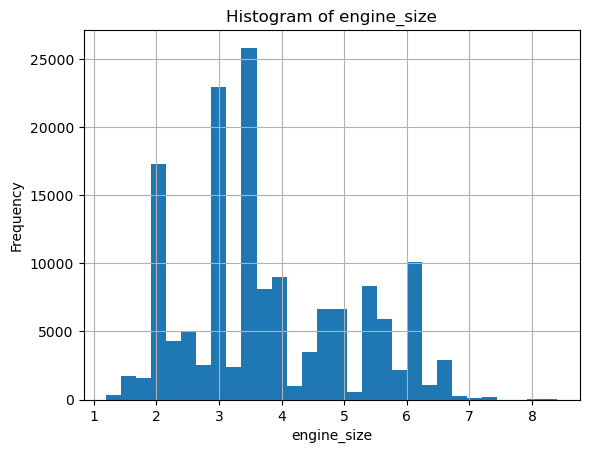

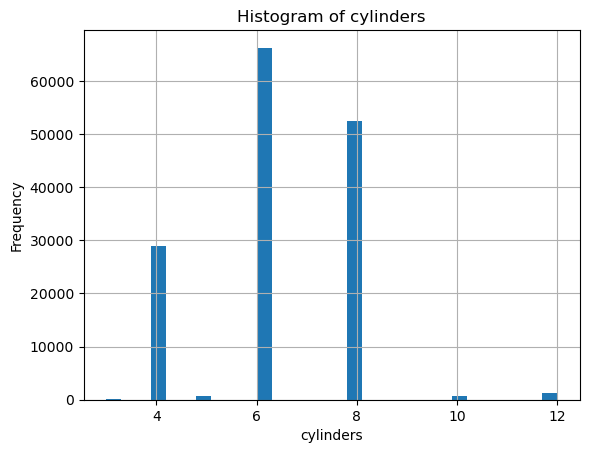

In [166]:
non_binary_columns = plot_non_binary_histograms(X_train)

In [204]:
X = add_log_columns(X_train, non_binary_columns)

In [205]:
y_log = np.log(y_train)

In [209]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 1. CatBoost
catboost_model = CatBoostRegressor(verbose=0, random_seed=42)
catboost_model.fit(X_train, y_train)
y_pred_cat = catboost_model.predict(X_valid)
rmse_cat = mean_squared_error(y_valid, y_pred_cat, squared=False)


# 2. XGBoost
xgboost_model = XGBRegressor(random_state=42)
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_valid)
rmse_xgb = mean_squared_error(y_valid, y_pred_xgb, squared=False)


# 3. LightGBM
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_valid)
rmse_lgbm = mean_squared_error(y_valid, y_pred_lgbm, squared=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4528
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 1692
[LightGBM] [Info] Start training from score 10.291494


In [210]:
_y_pred_cat = np.exp(y_pred_cat)
_y_pred_xgb = np.exp(y_pred_xgb)
_y_pred_lgbm = np.exp(y_pred_lgbm)
_y_valid = np.exp(y_valid)
rmse_cat = mean_squared_error(y_valid, _y_pred_cat, squared=False)
rmse_xgb = mean_squared_error(y_valid, _y_pred_xgb, squared=False)
rmse_lgbm = mean_squared_error(y_valid, _y_pred_lgbm, squared=False)
print(f'CatBoost RMSE: {rmse_cat}')
print(f'XGBoost RMSE: {rmse_xgb}')
print(f'LightGBM RMSE: {rmse_lgbm}')

CatBoost RMSE: 43578.280543696084
XGBoost RMSE: 43835.864459625016
LightGBM RMSE: 43416.1563695516


#### y_test

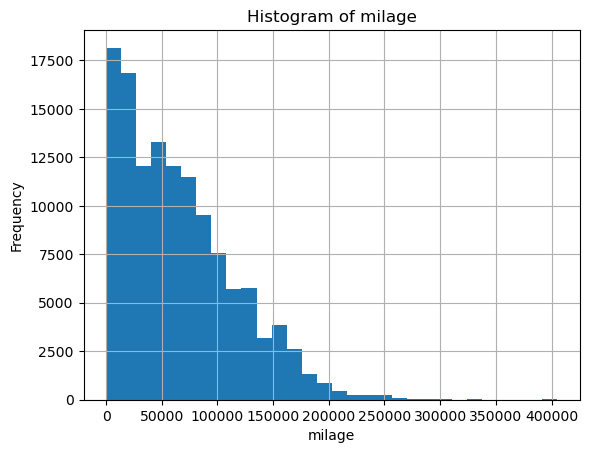

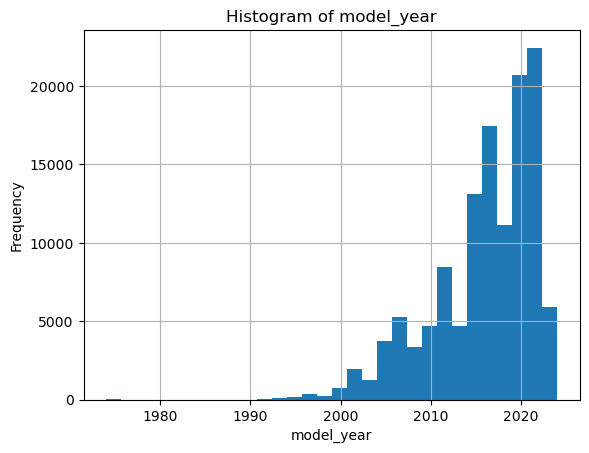

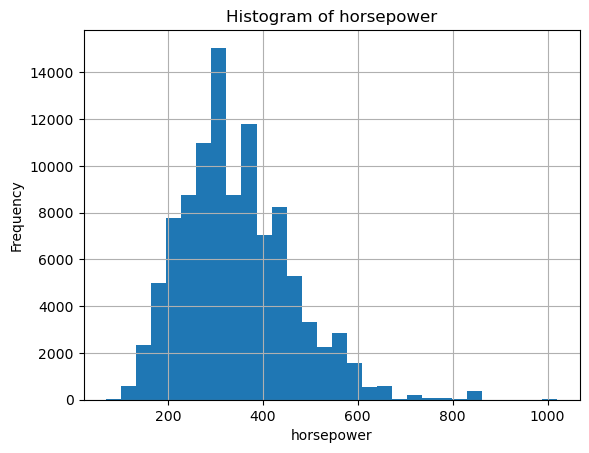

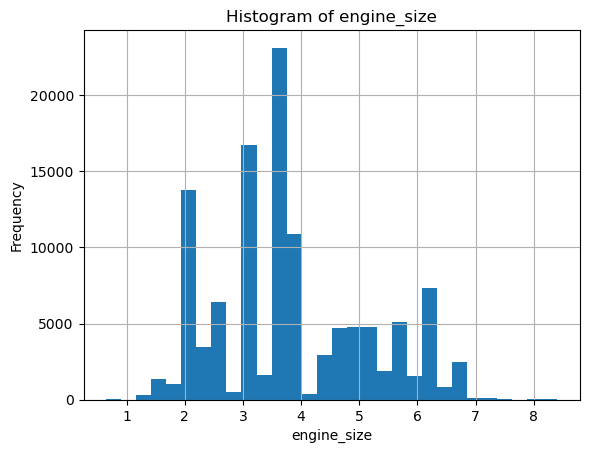

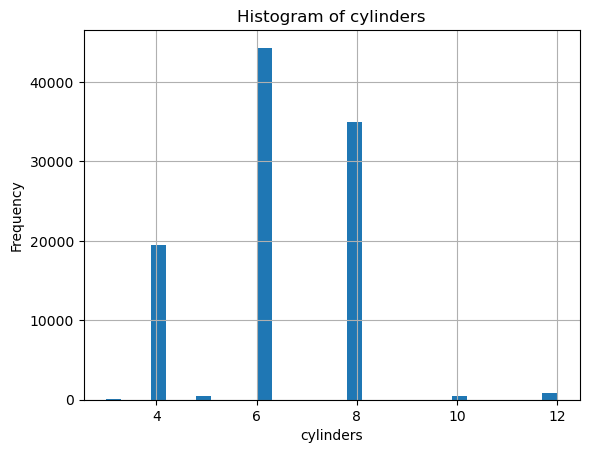

In [177]:
non_binary_columns = plot_non_binary_histograms(X_test)

In [211]:
X_test = add_log_columns(X_test, non_binary_columns)

In [212]:
y_test_pred_cat = catboost_model.predict(X_test)
y_test_pred_xgb = xgboost_model.predict(X_test)
y_test_pred_lgbm = lgbm_model.predict(X_test)

_y_test_pred_cat = np.exp(y_test_pred_cat)
_y_test_pred_xgb = np.exp(y_test_pred_xgb)
_y_test_pred_lgbm = np.exp(y_test_pred_lgbm)

# 重みを設定する
weight_cat = 0.4  # CatBoostに対する重み
weight_xgb = 0.3  # XGBoostに対する重み
weight_lgbm = 0.3  # LGBMに対する重み

# 重み付き平均を計算する
y_test_pred_ensemble = (
    weight_cat * _y_test_pred_cat +
    weight_xgb * _y_test_pred_xgb +
    weight_lgbm * _y_test_pred_lgbm
)

submission = pd.DataFrame(y_test_pred_ensemble)
test_data=pd.read_csv('./Data/playground-series-s4e9/test.csv')
test_data_index = test_data["id"]
submission.index = test_data_index
submission.columns = ["price"]

In [213]:
submission

,price
id,
188533,16097.972024
188534,59906.890938
188535,48927.994741
188536,26281.556921
188537,29216.876042
...,...
314218,23296.043258
314219,43088.745981
314220,19579.183383


In [214]:
submission.to_csv("submission2.csv")